In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pyvinecopulib as pv

from math import gamma
from scipy.stats import norm
from pydra_core import Profile

<h3>Determine expected damage without variation and interdependency</h3>

In [18]:
# Hydraulic loading
Hs = 1.0
s0p = 0.05
Rc = 2.0

# Dike
cota_waterside = 3.0
Bc = 5.0
cota_landward = 3.0
length_landward = 12
uc = 4.3

# Calculate Lmm10, Tspec, and Tm
Lmm10 = Hs / s0p
Tspec = np.sqrt(Lmm10 * 2 * np.pi / 9.81)
Tm = Tspec * (1.1 / 1.2)

# Create profile
prof = Profile()
prof.set_dike_geometry([-10 * cota_waterside, Rc * cota_waterside], [-10, Rc])
prof.set_dike_crest_level(Rc)
prof.set_dike_orientation(0)

# Calculate Ru2p and qavg (TAW (2002))
h = 0
Ru2p = prof.calculate_runup(h, Hs, Tspec, 0) - h
qavg = prof.calculate_overtopping(h, Hs, Tspec, 0)

# Calculate Pov (EurOtop (2018))
Pov = np.exp(-1 * (np.sqrt(- np.log(0.02)) * Rc / Ru2p)**2)

# Calculate individual overtopping volume distribution (Hughes et al. (2012), Zanuttigh et al. (2013))
b = 0.73 + 55 * ((qavg / 1000) / (9.81 * Hs * Tspec)) ** 0.8
a = (1 / (gamma(1 + 1 / b))) * (qavg * Tm / Pov)
vmax = a * (np.log(50000))**(1/b)
v = np.arange(0.0001, vmax, 0.0001)
p_v = (b / a) * (v / a)**(b-1) * np.exp(-(v / a)**b) * (v[1] - v[0])

# Calculate upeak and hpeak at waterside crest (Hughes (2017))
upeak_wsc = 27.67 * np.sqrt(v * (1 / cota_waterside)) / Tspec
hpeak_wsc = 0.324 * np.sqrt(v)

# Use van Bergeijk et al. (2019) to translate along crest
Q = upeak_wsc * hpeak_wsc
f = 0.01
upeak_lsc = 1 / ((f * Bc / (2 * Q)) + (1 / upeak_wsc))
hpeak_lsc = Q / upeak_lsc

# Use van Bergeijk et al. (2019) to translate along landward slope
alpha = (9.81 * np.sin(np.arctan(1 / cota_landward)))**(1/3)
beta = (f / (2 * Q))**(1/3)
mu = upeak_lsc - alpha / beta
u_toe = alpha / beta + mu * np.exp(-3 * alpha * beta**2 * length_landward)

# Calculate D using COM (van der Meer et al. (2011))
D = np.maximum(u_toe**2 - uc**2, 0)

# Numerical integration to obtain expected D
ED = np.sum(p_v * D)
print(f"Expected damage: {ED:.3f} m2/s2")
print("Check sum probabilities:", np.sum(p_v))

Expected damage: 1.566 m2/s2
Check sum probabilities: 0.9926790949126405


<h3>Determine expected damage with variation and interdependency</h3>

Use Monte Carlo to estimate the expected damage with variation and interdependency.

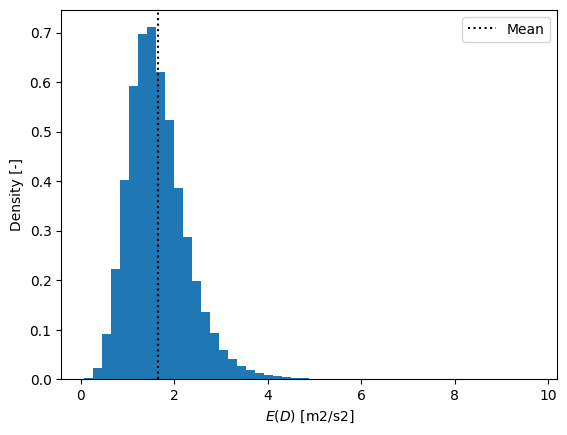

Expected damage with variation and interdependency: 1.653 m2/s2


In [19]:
# Parameters
sigma_u = 0.219 if cota_waterside==3 else 0.129
sigma_h = 0.196
copula_nu = 9.361
copula_rho = -0.497
n_samples = 100_000

# Create copula
cop = pv.Bicop.from_family(pv.BicopFamily.student, parameters=np.array([[copula_rho], [copula_nu]]))

# Perform Monte Carlo
cu, ch = cop.simulate(n_samples).T
Ru = norm(0, sigma_u).ppf(cu)
Rh = norm(0, sigma_h).ppf(ch)

# Calculate for each sample the expected D
ED = []
for _Ru, _Rh in zip(Ru, Rh):

    # Calculate upeak and hpeak at waterside crest (Hughes (2017))
    upeak_wsc = 27.67 * np.sqrt(v * (1 / cota_waterside)) / Tspec * np.exp(_Ru)
    hpeak_wsc = 0.324 * np.sqrt(v) * np.exp(_Rh)
    
    # Use van Bergeijk et al. (2019) to translate along crest
    Q = upeak_wsc * hpeak_wsc
    f = 0.01
    upeak_lsc = 1 / ((f * Bc / (2 * Q)) + (1 / upeak_wsc))
    hpeak_lsc = Q / upeak_lsc
    
    # Use van Bergeijk et al. (2019) to translate along landward slope
    alpha = (9.81 * np.sin(np.arctan(1 / cota_landward)))**(1/3)
    beta = (f / (2 * Q))**(1/3)
    mu = upeak_lsc - alpha / beta
    u_toe = alpha / beta + mu * np.exp(-3 * alpha * beta**2 * length_landward)

    # Calculate D using COM (van der Meer et al. (2011))
    D = np.maximum(u_toe**2 - uc**2, 0)
    ED.append(np.sum(p_v * D))

# Estimate expected D
plt.hist(ED, bins=50, density=True)
plt.axvline(np.mean(ED), color="black", ls=":", label="Mean")
plt.xlabel(r"$E(D)$ [m2/s2]")
plt.ylabel("Density [-]")
plt.legend()
plt.show()

print(f"Expected damage with variation and interdependency: {np.mean(ED):.3f} m2/s2")